# Creating sequential base model for text generation

This base model would try to predict text, treating it as a sequence of words.

Based on amazon food reviews, base model should be able to reproduce (at least, get close to) those reviews with sklearn algorithms.

## Load and analyze data

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
from tqdm import tqdm
from src.text_preprocessor import TextPreprocessor

tqdm.pandas()

reviews_df = pd.read_csv('../amazon-food-reviews.csv')
reviews_df.columns = [col_name.lower() for col_name in reviews_df.columns]
reviews_df = reviews_df[['text']]
reviews_df = reviews_df.drop_duplicates(subset=['text'])
reviews_df = reviews_df.dropna()
reviews_df.head()

,text
0,I have bought several of the Vitality canned d...
1,Product arrived labeled as Jumbo Salted Peanut...
2,This is a confection that has been around a fe...
3,If you are looking for the secret ingredient i...
4,Great taffy at a great price. There was a wid...


In [3]:
text_preprocessor = TextPreprocessor(lemmatization=False)

reviews_df['text'] = reviews_df['text'].progress_apply(text_preprocessor.process)
reviews_df['wc'] = reviews_df['text'].progress_apply(lambda x: len([word for word in x.split(' ') if word != '']))
reviews_df.describe()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dmitry\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|██████████| 393579/393579 [00:02<00:00, 183845.48it/s]


,wc
count,393579.000000
mean,44.132156
std,45.283719
min,0.000000
25%,18.000000
50%,30.000000
75%,53.000000
max,2092.000000


In [4]:
from sklearn.ensemble import IsolationForest

wc_isolation_forest = IsolationForest(contamination=0.2)

wc_vector = reviews_df['wc'].to_numpy().reshape((-1, 1))
print('Fitting...')
wc_isolation_forest.fit(wc_vector)

print('Predicting...')
outlier_mask = wc_isolation_forest.predict(wc_vector)
outlier_idx = outlier_mask == -1

filtered_reviews_df = reviews_df[~outlier_idx]
filtered_reviews_df.describe()

Fitting...
Predicting...


,wc
count,316435.000000
mean,31.007610
std,15.687982
min,11.000000
25%,18.000000
50%,27.000000
75%,41.000000
max,74.000000


<AxesSubplot:>

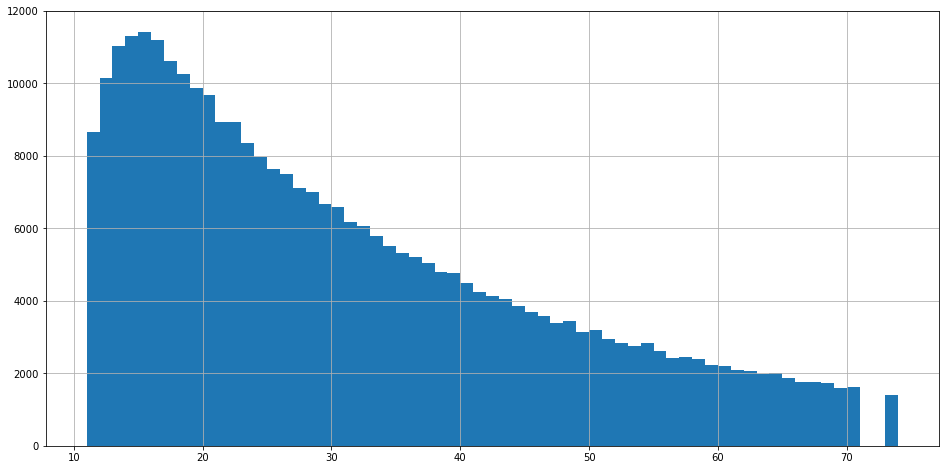

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

filtered_reviews_df['wc'].hist(bins=63, figsize=(16,8))

## Prepare data for training

<AxesSubplot:>

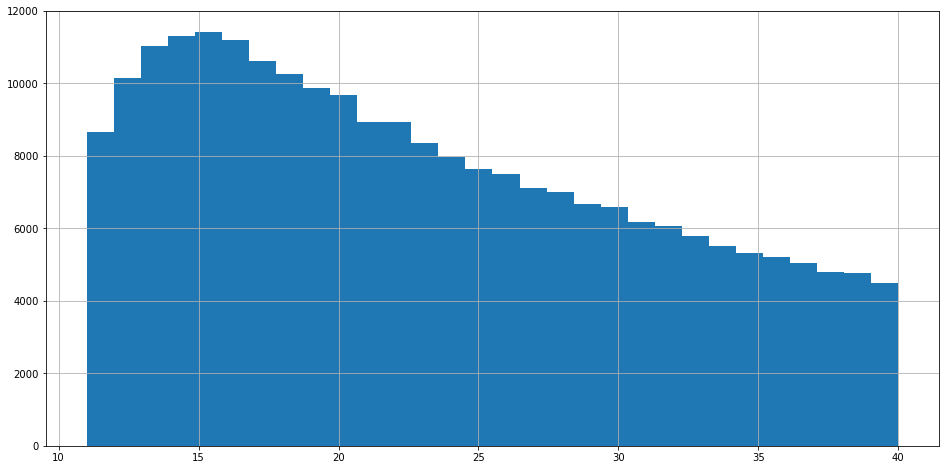

In [68]:
# Debug only!
max_word_count_forced = 41
filtered_reviews_df = filtered_reviews_df[filtered_reviews_df['wc'] < max_word_count_forced]
filtered_reviews_df['wc'].hist(bins=30, figsize=(16,8))

In [69]:
from src.embedding_manager import EmbeddingManager
import numpy as np

em = EmbeddingManager(path='../fasttext.wiki-news-cleaned-290d.vec')

start_token = '<start>'
end_token = '<end>'
pad_token = '<pad>'

# to make preprocessing easier to debug, at first words will be encoded with indicies
input_dict = {word: (i+3) for i, word in enumerate(tqdm(em.embeddings_dict.keys()))}

input_dict[start_token] = 1
input_dict[end_token] = 2
input_dict[pad_token] = 0

reversed_input_dict = {input_dict[key]: key for key in input_dict}

special_vectors = {
    start_token: np.full(em.shape, -2),
    end_token: np.full(em.shape, 2),
    pad_token: np.zeros(em.shape)
}
em.add_special_vectors(special_vectors)

100%|██████████| 611144/611144 [00:50<00:00, 12036.04it/s]


Total embeddings shape: (611143, 290)


100%|██████████| 611143/611143 [00:00<00:00, 1786985.24it/s]


Total embeddings shape: (611146, 290)


In [15]:
filtered_reviews_df['text'] = filtered_reviews_df['text'].apply(lambda row: f'{start_token} {row} {end_token}')

In [70]:
windowed_data = []
for _, row in tqdm(filtered_reviews_df.sample(n=50000).iterrows()):
    words = row['text'].split()
    for i in range(1, len(words)):
        text = ' '.join(words[:i])
        target_word = words[i]
        windowed_data.append({
            'text': text,
            'target_word': target_word
        })
        
windowed_df = pd.DataFrame(windowed_data)
windowed_df.describe()

50000it [00:03, 14977.04it/s]


,text,target_word
count,1209117,1209117
unique,1085641,29237
top,<start>,<end>
freq,50000,50000


In [71]:
def get_output(target_word):
    if target_word in text_preprocessor.stopwords:
        return -1
    if target_word not in input_dict:
        return -1
    
    return input_dict[target_word]

windowed_df['output'] = windowed_df['target_word'].progress_apply(get_output)
windowed_df = windowed_df[windowed_df['output'] != -1]

windowed_df['seq'] = windowed_df['text'].progress_apply(lambda row: [input_dict[word] for word in row.split() if word in input_dict])
windowed_df['wc'] = windowed_df['text'].progress_apply(lambda x: len([word for word in x.split() if word is not '']))
windowed_df['seq_len'] = windowed_df['seq'].progress_apply(lambda seq: len(seq))

# check how many entries lost more than 20% of words due to vocabulary limitations:
insufficient_vocabulary_df = windowed_df[(windowed_df['seq_len'] * 1.25 < windowed_df['wc'])]
insufficient_vocabulary_df.describe()

100%|██████████| 1115304/1115304 [00:01<00:00, 962020.36it/s] 


,output,wc,seq_len
count,3756.00000,3756.000000,3756.000000
mean,15176.52902,5.056443,3.617146
std,45468.85503,3.990269,3.061442
min,2.00000,2.000000,1.000000
25%,613.00000,3.000000,2.000000
50%,3298.00000,4.000000,3.000000
75%,10757.00000,4.000000,3.000000
max,580542.00000,41.000000,30.000000


In [72]:
clean_seq_reviews_df = windowed_df[~windowed_df.index.isin(insufficient_vocabulary_df.index)]
clean_seq_reviews_df.describe()

,output,wc,seq_len
count,1.111548e+06,1.111548e+06,1.111548e+06
mean,9.298141e+03,1.395751e+01,1.385359e+01
std,3.131294e+04,9.156544e+00,9.090966e+00
min,2.000000e+00,1.000000e+00,1.000000e+00
25%,3.660000e+02,6.000000e+00,6.000000e+00
50%,1.868000e+03,1.300000e+01,1.200000e+01
75%,6.666000e+03,2.000000e+01,2.000000e+01
max,6.110740e+05,4.100000e+01,4.100000e+01


### Balancing outputs

In [73]:
len(clean_seq_reviews_df['output'].unique())

24145

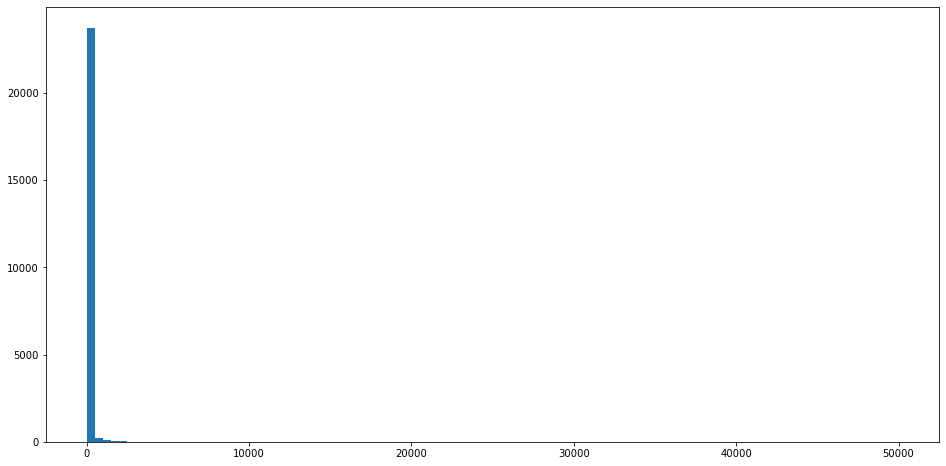

In [74]:
plt.figure(figsize=(16,8))
_ = plt.hist(clean_seq_reviews_df['output'].value_counts().values, bins=100)

Some outputs are absolutely dominating in terms of quantity.

In [75]:
target_words_df = clean_seq_reviews_df['target_word'].value_counts().to_frame()
target_words_df.head(25)

,target_word
<end>,49980
great,13425
good,13081
like,12687
br,11641
product,10315
taste,9946
love,9526
coffee,8399
flavor,8172


In [76]:
target_words_df.describe()

,target_word
count,24145.000000
mean,46.036364
std,444.972557
min,1.000000
25%,1.000000
50%,2.000000
75%,10.000000
max,49980.000000


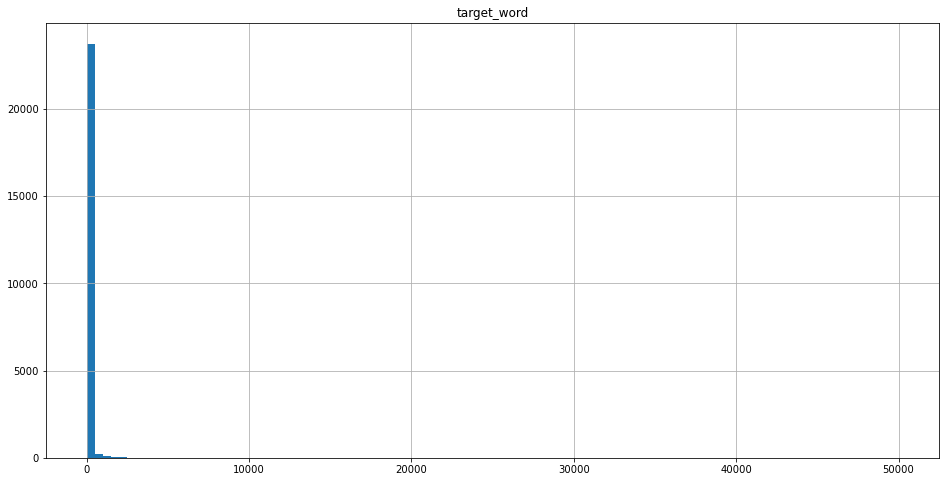

In [78]:
_ = target_words_df.hist(bins=100, figsize=(16,8))

With this target_word distribution it is impossible to get a good results.

More than a half of all words occured 1-2 times, so limiting by low occurence shouldn't be done, because it would damage the vocabulary (there could be some balancing and gentle filtering performed though). But the high end should be cropped.

Those high occuranced items should not be dropped, but reduced in quantity. Additionally, \<end> token could be a little bit out of balance, but not overly so.

In [85]:
max_examples = 5
balanced_df = clean_seq_reviews_df.groupby('output', group_keys=False).progress_apply(lambda group: group.sample(n=min(len(group.index), max_examples)))
balanced_df.describe()

100%|██████████| 24145/24145 [00:13<00:00, 1770.57it/s]


,output,wc,seq_len
count,69893.000000,69893.000000,69893.000000
mean,49700.023021,13.894396,13.776744
std,91823.392617,8.939735,8.866138
min,2.000000,1.000000,1.000000
25%,5225.000000,7.000000,7.000000
50%,15824.000000,12.000000,12.000000
75%,46688.000000,20.000000,20.000000
max,611074.000000,40.000000,40.000000


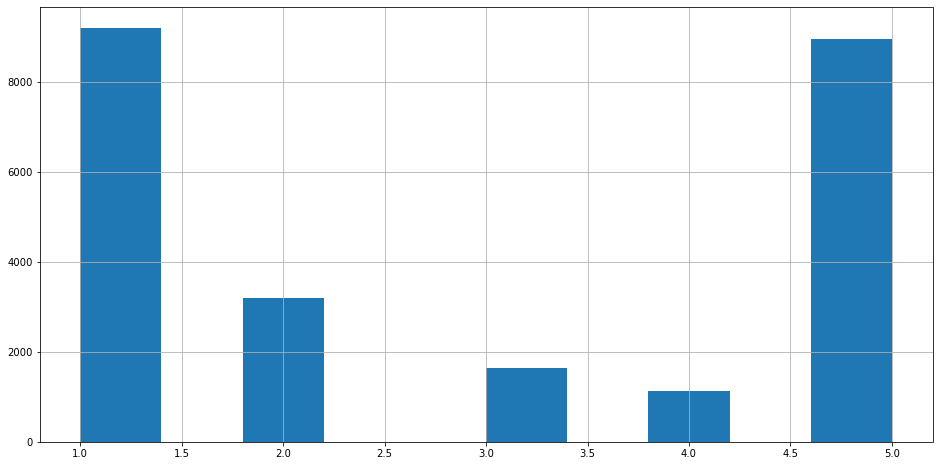

In [86]:
_ = balanced_df['output'].value_counts().hist(bins=10, figsize=(16,8))

In [88]:
end_token_samples = 500

end_token_sample_df = clean_seq_reviews_df[clean_seq_reviews_df['target_word'] == end_token].sample(n=end_token_samples)
balanced_df = balanced_df.append(end_token_sample_df)
balanced_df.describe()

,output,wc,seq_len
count,70393.000000,70393.000000,70393.000000
mean,49347.019008,13.964371,13.846519
std,91591.838059,8.973533,8.900383
min,2.000000,1.000000,1.000000
25%,5088.000000,7.000000,7.000000
50%,15605.000000,13.000000,12.000000
75%,46217.000000,20.000000,20.000000
max,611074.000000,41.000000,41.000000


#### Balancing conclusion

Exact algorithm for balancing in this particular example is a subject to change, but for now the most obvious problem was solved.

Additional topics:
1. Balance input phrases by length
2. Optimize the number of examples
3. Optimize the number of \<end> token examples

In [91]:
max_seq_len = balanced_df['seq_len'].max()
balanced_df['pad_seq'] = balanced_df['seq'].progress_apply(lambda seq: [0] * (max_seq_len - len(seq)) + seq)

100%|██████████| 70393/70393 [00:00<00:00, 425756.91it/s]


In [92]:
balanced_df.head()

,text,target_word,output,seq,wc,seq_len,pad_seq
990016,<start> like coffee purchasing amazon wish cou...,<end>,2,"[1, 53, 3345, 6109, 4066, 1445, 139, 2236, 677...",17,17,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
361893,<start> four foster cats time one always probl...,<end>,2,"[1, 265, 6829, 4723, 50, 32, 351, 260, 1191, 5...",28,28,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 265..."
669649,<start> aside around favorite gold bears harib...,<end>,2,"[1, 3394, 170, 4556, 1648, 5158, 88483, 245103...",25,25,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
371907,<start> dogs absolutely love treats love amazo...,<end>,2,"[1, 2798, 2692, 577, 7875, 577, 4066, 16606, 1...",15,15,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
242085,<start> purchased local health foods store lov...,<end>,2,"[1, 3239, 289, 470, 4391, 1471, 4029, 124, 575...",31,31,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3239, 289, 4..."


Encode data with embeddings

In [93]:
def encode_seq(seq):
    words = [reversed_input_dict[item] for item in seq]
    encoded = [em.get_vector(word) for word in words]
    return encoded

def get_arrayed_data(df_set):
    setX = np.stack(df_set['pad_seq'].progress_apply(encode_seq).values, axis=0)
    setY = np.stack(df_set['output'].progress_apply(lambda x: encode_seq([x])[0]).values, axis=0)        
    return (setX, setY)

In [101]:
trainX, trainY = get_arrayed_data(balanced_df.sample(n=400))
print(trainX.shape)
trainX = trainX.reshape((trainX.shape[0], trainX.shape[1] * trainX.shape[2]))
print(trainX.shape)
print(trainY.shape)

100%|██████████| 400/400 [00:00<00:00, 132920.42it/s]

(400, 41, 290)
(400, 11890)
(400, 290)


In [102]:
import time
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor

regressor = SVR()
mo_regressor = MultiOutputRegressor(estimator=regressor)
start_training = time.time()

mo_regressor.fit(trainX, trainY)
end_training = time.time()
print(f'Training finished, elapsed seconds: {end_training-start_training}')

Training finished, elapsed seconds: 84.53471636772156


Doubling train set size will increase training time in 3.4 times

### Producing result

In [103]:
def generate_sequence(initial_sentence, max_generated_length=max_seq_len):
    sentence = f'{start_token} {initial_sentence.lower()}'
    inapropriate_tokens = [start_token, pad_token]
    
    for i in tqdm(range(max_generated_length)):
        sequence = [input_dict[word] for word in sentence.split() if word in input_dict]
        if len(sequence) >= max_seq_len:
            return sentence

        padded_sequence = [0] * (max_seq_len - len(sequence)) + sequence

        encoded_sequence = encode_seq(padded_sequence)
        array = np.array(encoded_sequence)
        input_array = array.reshape(1, array.shape[0] * array.shape[1])
        result = mo_regressor.predict(input_array).reshape(em.shape)

        word_scores = em.get_words(result, k=3)
        for word_score in word_scores:
            word = word_score[0]
            if word not in inapropriate_tokens:
                new_word = word
                break
                
        sentence += ' ' + new_word

        if new_word == end_token:
            print('End token received.')
            return sentence

In [104]:
generate_sequence('I have bought')

  0%|          | 0/41 [00:00<?, ?it/s]

Estimator is being prepared...


 90%|█████████ | 37/41 [02:26<00:15,  3.97s/it]  


'<start> i have bought tehut tehut tehut 98311 tehut tehut 98311 tehut dibs tehut tehut 98311 sshhh tehut tehut tehut tehut fom fow quip tehut tehut riight tehut tehut tehut tehut tehut tehut denny tehut 98311 humdinger recommned tehut saddly similat'

In [105]:
generate_sequence('really this was an amazing stuff for me to find')

 73%|███████▎  | 30/41 [00:32<00:11,  1.08s/it]


'<start> really this was an amazing stuff for me to find tehut dibs tehut tehut 98311 sshhh tehut tehut tehut tehut fom fow quip tehut tehut riight tehut tehut tehut tehut tehut tehut denny tehut 98311 humdinger recommned tehut saddly similat'

In [106]:
generate_sequence('')

 98%|█████████▊| 40/41 [00:44<00:01,  1.11s/it]


'<start>  tehut deap tehut tehut tehut tehut 98311 tehut tehut 98311 tehut dibs tehut tehut 98311 sshhh tehut tehut tehut tehut fom fow quip tehut tehut riight tehut tehut tehut tehut tehut tehut denny tehut joanna humdinger recommned tehut saddly similat'

### Summary

Base model performs poorly, just as expected. 
1. Model uses flattened representation of input vector, due to the limitations of sklearn algorithms.
2. Because embeddings encoding had to take place before training, train set was reduced to fit in memory.
3. In addition to previous, because computational powers are limited, train set was additionally reduced.
4. While there is a possibility to choose words that might fit, it wasn't used.
5. Train set could be balanced better.